In [10]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import json
import math

In [11]:
# Load rotation vectors for each camera
rvecs = []
for cam in range(1, 8):
    with open(f'cam_{cam}/extrinsics/rvec.txt', 'r') as f:
        rvecs.append(np.array([float(x) for x in f.read().split()]))
print(rvecs[0])

[ 2.05018189  0.98840169 -0.57373535]


In [12]:
# Convert rotation vectors to rotation matrices 
rmat = [cv.Rodrigues(rvec)[0] for rvec in rvecs]

In [13]:
# Load translation vectors for each camera
tvecs = []
for cam in range(1, 8):
    with open(f'cam_{cam}/extrinsics/tvec.txt', 'r') as f:
        tvecs.append(np.array([float(x) for x in f.read().split()]))
print(tvecs[0])

[-134.25953329  -23.76099666  187.46374006]


In [14]:
# Construct camera to world transformation matrices
T = [np.eye(4) for _ in range(7)]
for i in range(7):
    T[i][:3, :3] = rmat[i]
    # Calculate determinant
    det = np.linalg.det(T[i][:3, :3])
    print(det)
    T[i][:3, 3] = tvecs[i]
    # Convert to coordinate system
    C = np.array([[-1, 0, 0, 0],
                  [0, 1, 0, 0],
                  [0, 0, 1, 0],
                  [0, 0, 0, 1]])
    T[i] = np.linalg.inv(T[i])
    # Calculate determinant
    det = np.linalg.det(T[i][:3, :3])
    print(det)
    T[i] = np.dot(T[i], C)
    # Calculate determinant
    det = np.linalg.det(T[i][:3, :3])
print(T[0])

1.0000000000000002
1.0
1.0
0.9999999999999998
0.9999999999999997
1.0000000000000002
1.0000000000000002
1.0
1.0000000000000007
0.9999999999999994
1.0000000000000007
0.9999999999999994
1.0000000000000002
0.9999999999999997
[[-5.96808242e-01  4.51155708e-01 -6.63534814e-01  2.15235823e+02]
 [-7.99931863e-01 -3.99142022e-01  4.48101172e-01  1.39117448e+01]
 [ 6.26812263e-02 -7.98213113e-01 -5.99105074e-01  8.49285866e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


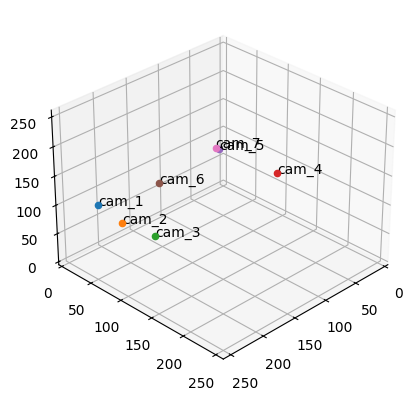

[215.23582324  13.91174479  84.92858663]
[222.83028378  62.6194555   85.29102521]
[213.56121903 106.7741115   83.29857378]
[ 11.34760956 101.31468336  78.72181949]
[16.97415157 10.24812395 77.67995148]
[168.26533769  65.68706106 126.71566945]
[ 58.86640633  46.09572383 120.57656203]


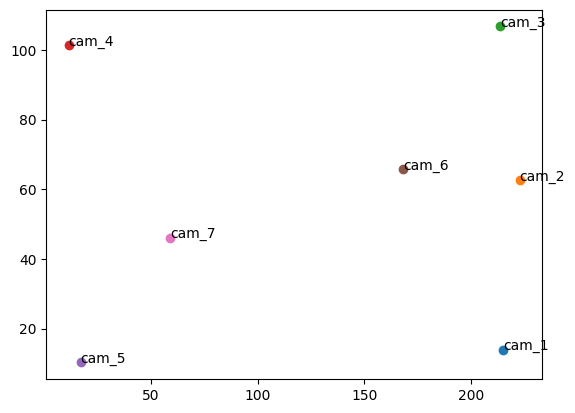

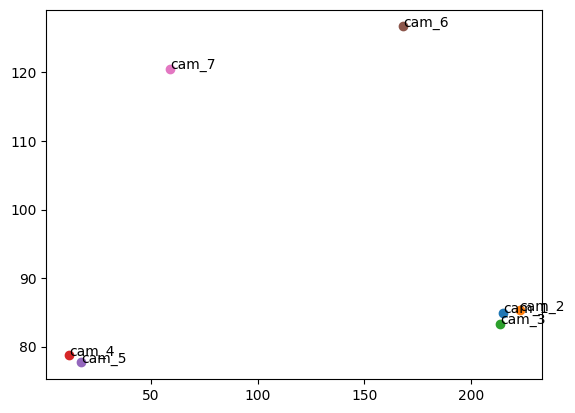

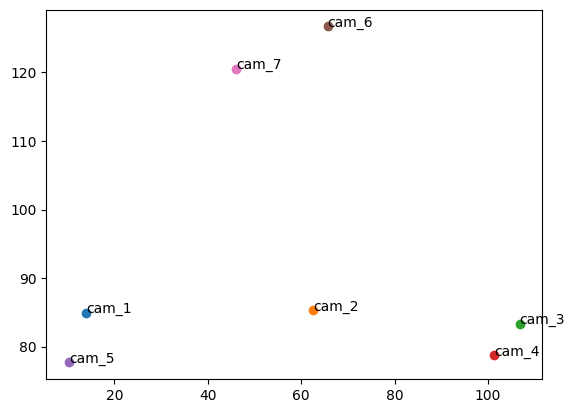

In [15]:
# Plot the camera positions in 3D
coords_3d = [T[i][:3, 3] for i in range(7)]
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for i, coord in enumerate(coords_3d):
    ax.scatter(coord[0], coord[1], coord[2], label=f'cam_{i+1}')
    ax.text(coord[0], coord[1], coord[2], f'cam_{i+1}')
    ax.view_init(elev=30, azim=45)
    # Make axes start at 0 and end at max value
    ax.set_xlim([0, 256])
    ax.set_ylim([0, 256])
    ax.set_zlim([0, 256])

plt.show()
tvecs_temp = [T[i][:3, 3] for i in range(7)]
for vec in tvecs_temp:
    print(vec)
coords_3d = tvecs_temp
# Plot the xy coordinates of the cameras
fig, ax = plt.subplots()
for i, coord in enumerate(coords_3d):
    ax.scatter(coord[0], coord[1], label=f'cam_{i+1}')
    ax.annotate(f'cam_{i+1}', (coord[0], coord[1]))
plt.show()
# Plot the xz coordinates of the cameras
fig, ax = plt.subplots()
for i, coord in enumerate(coords_3d):
    ax.scatter(coord[0], coord[2], label=f'cam_{i+1}')
    ax.annotate(f'cam_{i+1}', (coord[0], coord[2]))
plt.show()
# Plot the yz coordinates of the cameras
fig, ax = plt.subplots()
for i, coord in enumerate(coords_3d):
    ax.scatter(coord[1], coord[2], label=f'cam_{i+1}')
    ax.annotate(f'cam_{i+1}', (coord[1], coord[2]))
plt.show()

In [16]:
# Load intrinsic matrices for each camera
K = []
for cam in range(1, 8):
    with open(f'cam_{cam}/intrinsics/cameraMatrix.txt', 'r') as f:
        K.append(np.array([float(x) for x in f.read().split()]).reshape(3, 3))
print(K[0])

[[1.08437970e+03 0.00000000e+00 8.55671508e+02]
 [0.00000000e+00 1.06331702e+03 5.57359735e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]


In [17]:
# Construct transforms.json in instant-ngp format
transforms = {}
transforms['w'] = 1920.0
transforms['h'] = 1080.0
transforms['aabb_scale'] = 1.0
transforms['scale'] = 0.004
transforms['offset'] = [0.0, 0.2, 0.3]
frames = []
for i in range(7):
    frame = {}
    frame['file_path'] = f'c{i+1}undistorted.png'
    frame['transform_matrix'] = T[i].tolist()
    frame['f1_x'] = K[i][0, 0]
    frame['f1_y'] = K[i][1, 1]
    frame['camera_angle_x'] = 2 * math.atan(1080 / (2 * K[i][0, 0]))
    frame['camera_angle_y'] = 2 * math.atan(1920 / (2 * K[i][1, 1]))
    frame['c1_x'] = K[i][0, 2]
    frame['c1_y'] = K[i][1, 2]
    frames.append(frame)
transforms['frames'] = frames

In [18]:
# Write transforms to file
with open('transforms.json', 'w') as f:
    json.dump(transforms, f, indent=4)